```
This file is part of connectome-manipulator.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Connectome wiring example

Working example to wire an empty connectome from scratch.

## Download example circuit

Download and uncompress the SONATA toy circuit from ZENODO (DOI [10.5281/zenodo.12202780](https://doi.org/10.5281/zenodo.12202780)) which contains a circuit config without connectome, or use any other network model in SONATA format without connectome. Set path to circuit config below.

In [1]:
# Path to SONATA circuit config WITHOUT CONNECTOME
circuit_config = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config__no_conn.json'

## Stochastic model definition

Before we can run rewiring, we need to define the stochastic connectivity model as well as stochastic model descriptions for physiological parameters. We can either reuse (and modify) them from other connectomes, or define them manually using some default values as shown in this example.

In [2]:
from bluepysnap import Circuit
from connectome_manipulator.model_building import model_types

In [3]:
model_path = './model_building/model'

In [4]:
# Connection probability model: 2nd-order (distance-dependent) connection probabilities
conn_model = model_types.ConnProb2ndOrderExpModel(scale=0.11, exponent=0.007)
conn_model.save_model(model_path, 'ConnProb2ndOrderModel')
print(conn_model)


ConnProb2ndOrderExpModel
  p_conn(d) = 0.110 * exp(-0.007 * d)
  d...distance


In [5]:
# Axonal delay model: Linear distance-dependent delays between pre-synaptic neuron and post-synaptic synapse position
delay_model = model_types.LinDelayModel(delay_mean_coeff_a=0.75, delay_mean_coeff_b=0.003, delay_std=0.5, delay_min=0.2)
delay_model.save_model(model_path, 'LinDelayModel')
print(delay_model)


LinDelayModel
  Model properties: ['delay_mean_coeff_a', 'delay_mean_coeff_b', 'delay_std', 'delay_min']
  Default: {'delay_mean_coeff_a': 0.75, 'delay_mean_coeff_b': 0.003, 'delay_std': 0.5, 'delay_min': 0.2}


In [6]:
# Physiological properties model: Pathway-specific parameter distributions for all pairs of m-types
# (In this example, we use same the exact same distributions for all pathways!)

c = Circuit(circuit_config)
mtypes = sorted(c.nodes.property_values('mtype'))
mtypes_class = [c.nodes["All"].get({"mtype": _mt}, properties="synapse_class").iloc[0] for _mt in mtypes]  # Synapse class (EXC or INH)
print(f"{len(mtypes)} m-types: [{mtypes[:3] + ['...'] + mtypes[-3:]}]")

# Example values for EXC synapses
distr_types_exc = {
    "conductance": {"type": "gamma", "mean": 1.0, "std": 0.5},
    "conductance_scale_factor": {"type": "constant", "mean": 0.7},
    "decay_time": {"type": "truncnorm", "norm_loc": 1.7, "norm_scale": 0.1, "min": 1.7, "max": 1.9},
    "depression_time": {"type": "gamma", "mean": 670.0, "std": 15.0},
    "facilitation_time": {"type": "gamma", "mean": 17.0, "std": 5.0},
    "n_rrp_vesicles": {"type": "discrete", "val": [1, 2, 3, 4, 5], "p": [0.3, 0.3, 0.2, 0.1, 0.1], "dtype": "int"},
    "n_syn_per_conn": {"type": "gamma", "mean": 3.0, "std": 1.5, "lower_bound": 1, "upper_bound": 1000, "dtype": "int"},
    "syn_type_id": {"type": "constant", "mean": 100, "dtype": "int"},
    "u_hill_coefficient": {"type": "constant", "mean": 2.79},
    "u_syn": {"type": "truncnorm", "norm_loc": 0.5, "norm_scale": 0.25, "min": 0.2, "max": 0.7},
}

# Example values for INH synapses
distr_types_inh = {
    "conductance": {"type": "gamma", "mean": 2.0, "std": 0.5},
    "conductance_scale_factor": {"type": "constant", "mean": 0.0},
    "decay_time": {"type": "truncnorm", "norm_loc": 8.0, "norm_scale": 1.0, "min": 6.0, "max": 10.0},
    "depression_time": {"type": "gamma", "mean": 700.0, "std": 300.0},
    "facilitation_time": {"type": "gamma", "mean": 20.0, "std": 8.0},
    "n_rrp_vesicles": {"type": "discrete", "val": [1], "p": [1.0], "dtype": "int"},
    "n_syn_per_conn": {"type": "gamma", "mean": 6.0, "std": 1.5, "lower_bound": 1, "upper_bound": 1000, "dtype": "int"},
    "syn_type_id": {"type": "constant", "mean": 1, "dtype": "int"},
    "u_hill_coefficient": {"type": "constant", "mean": 1.94},
    "u_syn": {"type": "truncnorm", "norm_loc": 0.25, "norm_scale": 0.1, "min": 0.1, "max": 0.4},
}

prop_stats = {
    _prop: {
        _src: {
            _tgt: distr_types_exc[_prop] if _sclass == "EXC" else distr_types_inh[_prop] for _tgt in mtypes
        } for _src, _sclass in zip(mtypes, mtypes_class)
    } for _prop, _distr in distr_types_exc.items()
}

props_model = model_types.ConnPropsModel(src_types=mtypes, tgt_types=mtypes, prop_stats=prop_stats)
props_model.save_model(model_path, 'ConnPropsModel')
print(props_model)


60 m-types: [['L1_DAC', 'L1_HAC', 'L1_LAC', '...', 'L6_TPC:A', 'L6_TPC:C', 'L6_UPC']]
ConnPropsModel (with #syn/conn)
  Connection/synapse property distributions between 60x60 M-types:
  conductance <gamma>; conductance_scale_factor <constant>; decay_time <truncnorm>; depression_time <gamma>; facilitation_time <gamma>; n_rrp_vesicles <discrete (int)>; n_syn_per_conn <gamma (int)>; syn_type_id <constant (int)>; u_hill_coefficient <constant>; u_syn <truncnorm>


## Connectome wiring

Setup and run connectome wiring. We need to run wiring in two separate iterations for EXC and INH synapses respectively.

❗ Adjust `run_rewiring_parallel.sh` according to SLURM configuration<br>
❗ Set "circuit_config" and "model_config" in `manip_config__ConnWire.json` accordingly (for both EXC and INH wiring)

<u>Note</u>: We can specify all synapse properties to be generated (incl. data types) in `manip_config__ConnWire.json` under "syn_props_init". These properties should be consistent with the used ConnPropsModel!

Run connectome wiring using one of the following launch commands:

__Launch command - Serial processing__

~~~
connectome-manipulator -v manipulate-connectome "manip_config__ConnWire.json" --output-dir="/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch" --parallel --profile --convert-to-sonata --splits=500
~~~

❗ Set `output-dir=...` accordingly (must be an absolute path)<br>
❗ `--convert-to-sonata` requires `parquet-converters`

__Launch command - Parallel processing on MPI cluster using SLURM__

~~~
sbatch run_rewiring_parallel.sh "manip_config__ConnWire.json" "/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch" 500
~~~

❗ Adjust `run_rewiring_parallel.sh` according to SLURM configuration<br>
❗ Set output directory accordingly (must be an absolute path)<br>
❗ Requires `parquet-converters` and `mpi4py`


__Output (example):__

~~~
Autoloading python/3.10.8
Autoloading intel-oneapi-mkl/2021.4.0
Autoloading hpe-mpi/2.25.hmpt
Autoloading python/3.10.8
Autoloading hpe-mpi/2.25.hmpt
Autoloading python/3.10.8
Autoloading hpe-mpi/2.25.hmpt
+ srun dplace parallel-manipulator -v manipulate-connectome manip_config__ConnWire.json --output-dir=/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch --parallel --profile --convert-to-sonata --splits=500
Dashboard URL: r1i7n30.bbp.epfl.ch:8787
[INFO] Log file "/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch/logs/connectome_manipulation_2024-07-03_09h37.log" created!
[INFO] Version: connectome_manipulator 0.0.11.dev1
[INFO] Loading circuit from /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config__no_conn.json
[INFO] Setting up 500 processing batch jobs...
[INFO] Starting Execution context
[INFO] Start job submission
[INFO] Split 1/500: Wiring connectome targeting 12 neurons
[INFO] Split 2/500: Wiring connectome targeting 12 neurons
...
[INFO] [100%] Finished 500 (out of 500) splits
[INFO] DASK jobs finished
[INFO] Shutting down DASK workers gracefully
[INFO] Done processing
[INFO]   Total input/output synapse counts: 0/473275 (Diff: 473275)
[INFO] Converting 494 (non-empty) .parquet file(s) to SONATA
[INFO] Deleting 494 temporary .parquet file(s), "_metadata" file, and "parquet.DONE"
[INFO] Creating SONATA config /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch/circuit_config.json
[INFO] +=============================================== PROFILER STATS ===============================================+
[INFO] |                Event Label                 | Min.Time | Avg.Time | Max.Time | Min.Mem  | Avg.Mem  | Max.Mem  |
[INFO] +--------------------------------------------------------------------------------------------------------------+
[INFO] | connectome_manipulation_main               |    85.81 |    85.81 |    85.81 |     0.01 |     0.01 |     0.01 |
[INFO] | processing                                 |     4.71 |    18.25 |    47.90 |     0.00 |     0.02 |     0.06 |
[INFO] |   conn_rewiring                            |     2.31 |     8.99 |    29.92 |     0.00 |     0.01 |     0.04 |
[INFO] |   write_to_parquet                         |     0.00 |     0.01 |     0.13 |     0.00 |     0.00 |     0.00 |
[INFO] +--------------------------------------------------------------------------------------------------------------+
~~~



## Check wired circuit

<u>Note</u>: Note the new edges population name that has been assigend automatically!

In [7]:
# Load circuit
c = Circuit('/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch/circuit_config.json')
nodes = c.nodes['All']
edges = c.edges['All__All__chemical']
print(f'Wired circuit with {nodes.size} neurons and {edges.size} synapses')
print(f'Synapse properties: {edges.property_names}')

Wired circuit with 5924 neurons and 473275 synapses
Synapse properties: {'afferent_center_y', 'delay', 'afferent_section_id', 'afferent_center_x', 'conductance', 'facilitation_time', 'afferent_section_type', 'depression_time', '@source_node', 'n_rrp_vesicles', 'afferent_center_z', 'conductance_scale_factor', 'syn_type_id', '@target_node', 'decay_time', 'u_syn', 'u_hill_coefficient', 'afferent_section_pos'}


## Structural comparison

After connectome manipulation, setup and run structural comparison.

### Step 1: Set circuits and paths in structural comparator config

Set the following paths in `structcomp_config__Orig_vs_Manip.json`:
- Under "circuits", set paths to original and manipulated circuit configs.
- Under "working_dir" and "out_dir", set working directory (for cached data) and output directory. Both can be set the same directory.

<u>Note</u>: Since the original circuit we used here does not have a connectome, we cannot use it for structural comparison. Therefore, compare the wired circuit to the original circuit <u>with</u> connectome!

### Step 2: Configure comparison plots

Under "plot_types" in `structcomp_config__Orig_vs_Manip.json`, the list of comparison plots can be modified. In this example, the following plots are pre-configured:

- "ConnPerLayer": Connection probability and number of synapses per connection for all pairs of layers.
- "ConnPerMtype": Connection probability and number of synapses per connection for all pairs of m-types.
- "PropsPerMtype": Mean value of selected pyhsiological synapse properties (e.g., conductance, delay, ...) for all pairs of m-types.
- "Adjacency": Adjacency matrix between all neurons.

### Step 3: Run structural comparison

❗ Adjust `run_struct_comparison.sh` according to SLURM configuration<br>

__Launch command:__

~~~
sbatch run_struct_comparison.sh structcomp_config__Orig_vs_Manip.json
~~~

__Output (example):__

~~~
VERSION INFO: connectome_manipulator 0.0.11.dev1
INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config.json
  /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_WiredFromScratch/circuit_config.json
INFO: Preparing "ConnPerLayer" plot(s)...
INFO: Computing connectivity (group_by=layer, sel_src={}, sel_dest={}, N=6x6 groups)
  0% |                                                                        |
 16% |############                                                            |
 33% |########################                                                |
 50% |####################################                                    |
 66% |################################################                        |
 83% |############################################################            |
100% |########################################################################|
INFO: Writing resutls to /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/wire_connectome/struct_comparison/data/Orig_ConnPerLayer.pickle
INFO: Computing connectivity (group_by=layer, sel_src={}, sel_dest={}, N=6x6 groups)
  0% |                                                                        |
 16% |############                                                            |
 33% |########################                                                |
 50% |####################################                                    |
 66% |################################################                        |
 83% |############################################################            |
100% |########################################################################|
INFO: Writing resutls to /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/wire_connectome/struct_comparison/data/Manip_ConnPerLayer.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/wire_connectome/struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer-nsyn_conn.png...
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/wire_connectome/struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer-conn_prob.png...
...
~~~

__Re-plot exemplary results within notebook__

In [52]:
import matplotlib.pyplot as plt
def plot_img(fn, figsize=(5, 3)):
    img = plt.imread(fn)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

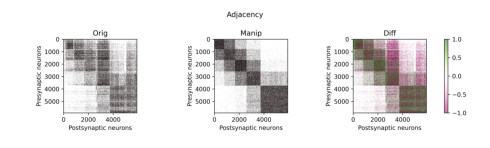

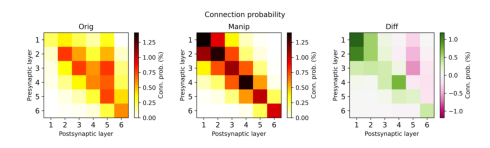

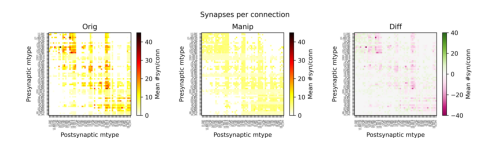

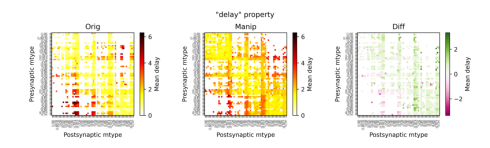

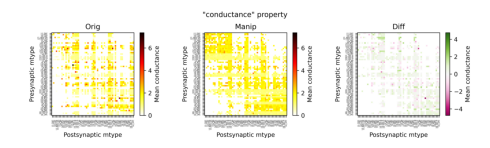

In [56]:
# Visualize structural comparison results (examples)
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-Adjacency-adj.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer-conn_prob.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-ConnPerMtype-nsyn_conn.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-PropsPerMtype-delay.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-PropsPerMtype-conductance.png')